In [1]:
# Plotting a file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%load_ext autoreload
%autoreload 2
import utils


## 0. Download data


To reproduce, download the oscilliscope data in this [Google Drive link](https://drive.google.com/drive/folders/1xMx-rKDBBPWpVfSlJJGTFtPv0_S3TEqP?usp=sharing). Then, place it in a folder called `data`.


## 1. Sample data


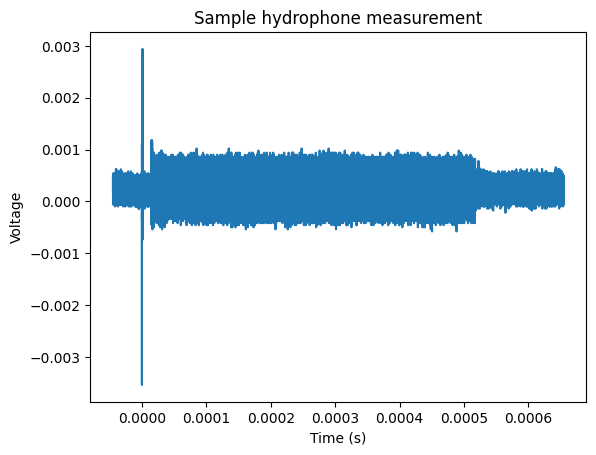

In [2]:
i = 128

filename = f"data/SDS{i:05d}.dat"

# For example, if the .dat file is CSV-like
df = pd.read_csv(filename, delimiter=",", header=None)
d = df.to_numpy()
t = d[:, 0]
y = d[:, 2]
plt.plot(d[:, 0], d[:, 2])
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.title("Sample hydrophone measurement")

plt.show()

## 2. Compute power drop across skull


In [3]:
# Read the metadata.csv file
metadata = pd.read_csv("metadata.csv")

In [4]:
# Create a function to get power for a specific position and skull state
def get_power_for_position(col, row, freq, skull_position):
    row_data = metadata[
        (metadata["Column"] == col)
        & (metadata["Row"] == row)
        & (metadata["Position"] == skull_position)
        & (metadata["Frequency (MHz)"] == freq)
    ]

    if row_data.empty:
        return np.nan

    file_num = row_data["SDS Sample #"].values[0]
    if pd.isna(file_num) or not utils.is_integer(file_num):
        return np.nan
    return utils.compute_power(int(file_num), freq_Hz=freq * 1e6, denoise=True)


# drop rows with Ignore == True
metadata = metadata[metadata["Ignore"] != 1]

# Get unique positions
positions = metadata[["Column", "Row", "Frequency (MHz)"]].drop_duplicates()

# Create a list to store results
results = []

# Iterate through positions
for _, position in positions.iterrows():

    col, row, freq = (
        position["Column"],
        position["Row"],
        position["Frequency (MHz)"],
    )

    # Get power for skull position 0 and 1
    power_no_skull = get_power_for_position(col, row, freq, "Water")
    power_skull1 = get_power_for_position(col, row, freq, "Skull Position 1")
    power_skull2 = get_power_for_position(col, row, freq, "Skull Position 2")

    # Check if the position exists for both skull positions
    if np.isnan(power_no_skull) and np.isnan(power_skull1) and np.isnan(power_skull2):
        print(
            f"Ignoring position (Column: {col}, Row: {row}) as it doesn't exist for either skull position."
        )
    elif np.isnan(power_no_skull):
        print(
            f"Ignoring position (Column: {col}, Row: {row}) as it doesn't exist for skull position 0."
        )
    elif np.isnan(power_skull1) and np.isnan(power_skull2):
        print(
            f"Ignoring position (Column: {col}, Row: {row}) as it doesn't exist for skull position 1."
        )
    else:
        results.append(
            {
                "Column": col,
                "Row": row,
                "Power (No Skull)": power_no_skull,
                "Power (Skull 1)": power_skull1,
                "Power (Skull 2)": power_skull2,
                "Frequency (MHz)": freq,
                "Attenuation_1 (dB)": 10 * np.log10(power_no_skull / power_skull1),
                "Attenuation_2 (dB)": 10 * np.log10(power_no_skull / power_skull2),
            }
        )

# Create a DataFrame from the results
result_df = pd.DataFrame(results)

# Display the table
print(result_df.to_string(index=False))

# Optionally, you can save this to a CSV file
# result_df.to_csv('power_comparison.csv', index=False)

 Column  Row  Power (No Skull)  Power (Skull 1)  Power (Skull 2)  Frequency (MHz)  Attenuation_1 (dB)  Attenuation_2 (dB)
      2    3      1.821400e-10     2.586172e-11     1.262813e-11                1            8.477480           11.590663
      2    3      9.591147e-15     7.681409e-16     7.394266e-16                2           10.964297           11.129755
      2    3      1.156058e-14     2.978350e-15     3.711592e-16                3            5.890039           14.934193
      2    3      6.255382e-15     3.528147e-16     6.673288e-17                4           12.487071           19.719139
      2    4      3.622223e-11     1.020641e-10     1.989924e-11                1           -4.498977            2.601386
      2    4      5.777631e-15     1.214445e-15     3.372609e-16                2            6.773718           12.337838
      2    4      1.112346e-14     3.567457e-15     1.837955e-16                3            4.938813           17.819051
      2    4      3.8447

In [5]:
# Calculate average intensities for each frequency and skull condition
avg_intensities = (
    result_df.groupby("Frequency (MHz)")
    .agg(
        {
            "Power (No Skull)": "mean",
            "Power (Skull 1)": "mean",
            "Power (Skull 2)": "mean",
        }
    )
    .reset_index()
)

# Rename columns for clarity
avg_intensities.columns = [
    "Frequency (MHz)",
    "Avg Power (No Skull)",
    "Avg Power (Skull 1)",
    "Avg Power (Skull 2)",
]

# Calculate attenuation for average intensities
avg_intensities["Avg Attenuation_1 (dB)"] = 10 * np.log10(
    avg_intensities["Avg Power (No Skull)"] / avg_intensities["Avg Power (Skull 1)"]
)
avg_intensities["Avg Attenuation_2 (dB)"] = 10 * np.log10(
    avg_intensities["Avg Power (No Skull)"] / avg_intensities["Avg Power (Skull 2)"]
)

# Display the results
print("Average Intensities and Attenuation for each Frequency:")
print(avg_intensities.to_string(index=False))

Average Intensities and Attenuation for each Frequency:
 Frequency (MHz)  Avg Power (No Skull)  Avg Power (Skull 1)  Avg Power (Skull 2)  Avg Attenuation_1 (dB)  Avg Attenuation_2 (dB)
               1          3.973370e-10         2.033134e-10         4.771177e-11                2.909930                9.205336
               2          2.424663e-14         4.688758e-15         5.045651e-16                7.135935               16.817341
               3          3.897182e-14         9.897500e-15         1.984766e-16                5.952251               22.930414
               4          2.083131e-14         4.159256e-15         1.053668e-16                6.997009               22.960128


## 3. Plot


removing 4 mhz data


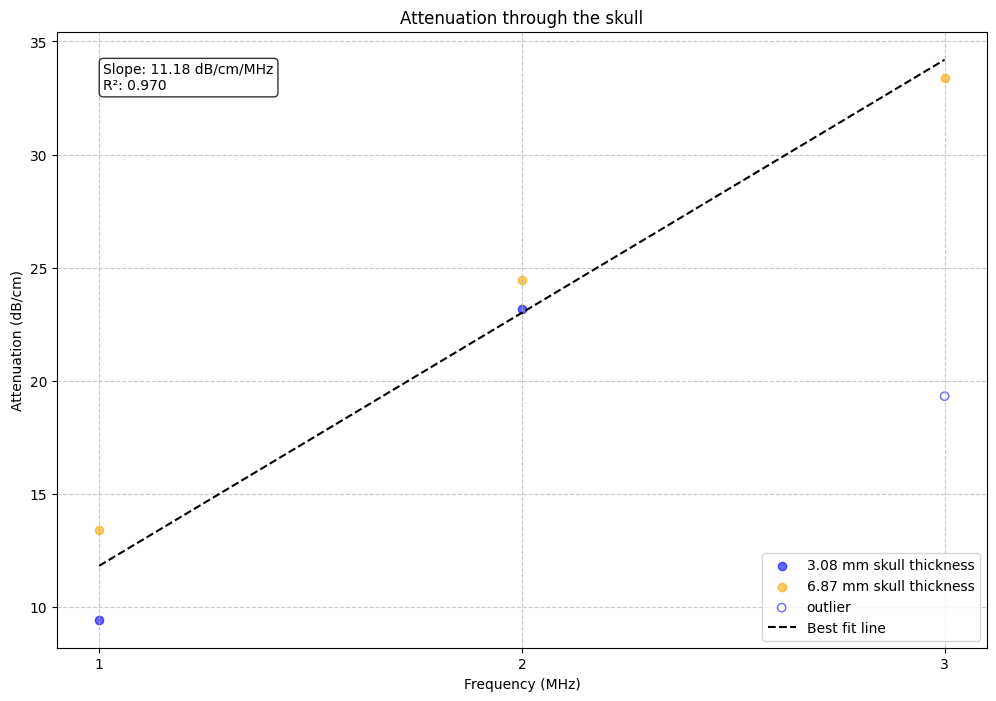

In [6]:
# Remove rows corresponding to frequency of 4 MHz
avg_intensities = avg_intensities[avg_intensities["Frequency (MHz)"] != 4]

print("removing 4 mhz data")


# Create a scatter plot of Attenuation vs Frequency for both Attenuation_1 and Attenuation_2
plt.figure(figsize=(12, 8))

thickness = [3.08, 6.87]
# Remove the outlier at 3 MHz
outlier_3mhz = avg_intensities[avg_intensities["Frequency (MHz)"] == 3]
avg_intensities_no_outlier = avg_intensities[avg_intensities["Frequency (MHz)"] != 3]

# Plot Attenuation_1 without the outlier
plt.scatter(
    avg_intensities_no_outlier["Frequency (MHz)"],
    avg_intensities_no_outlier["Avg Attenuation_1 (dB)"] / (thickness[0] / 10),
    alpha=0.6,
    color="blue",
    label=f"{thickness[0]} mm skull thickness",
    # s=20,  # Reduced spot size
)


plt.scatter(
    avg_intensities["Frequency (MHz)"],
    avg_intensities["Avg Attenuation_2 (dB)"] / (thickness[1] / 10),
    alpha=0.6,
    color="orange",
    # s=20,  # Reduced spot size
    label=f"{thickness[1]} mm skull thickness",
)
# Plot the outlier at 3 MHz separately as a blue circle outline
plt.scatter(
    outlier_3mhz["Frequency (MHz)"],
    outlier_3mhz["Avg Attenuation_1 (dB)"] / (thickness[0] / 10),
    facecolors="none",
    edgecolors="blue",
    alpha=0.6,
    label="outlier",
    # s=20,  # Reduced spot size
)

# Calculate and plot average attenuation for each frequency
avg_attenuation_1 = result_df.groupby("Frequency (MHz)")["Attenuation_1 (dB)"].mean()
avg_attenuation_2 = result_df.groupby("Frequency (MHz)")["Attenuation_2 (dB)"].mean()

# Set labels and title
plt.xlabel("Frequency (MHz)")
plt.ylabel("Attenuation (dB/cm)")
plt.title("Attenuation through the skull")

# Add a grid for better readability
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

# Set x-axis to show only integer numbers
plt.xticks(
    range(
        int(min(avg_intensities["Frequency (MHz)"])),
        int(max(avg_intensities["Frequency (MHz)"])) + 1,
    )
)

# Prepare data for linear regression
frequencies = np.tile(avg_intensities["Frequency (MHz)"], 2)
attenuations = np.concatenate(
    [
        avg_intensities["Avg Attenuation_1 (dB)"] / (thickness[0] / 10),
        avg_intensities["Avg Attenuation_2 (dB)"] / (thickness[1] / 10),
    ]
)

# remove the data point that's at 3 MHz and for skull position 1
mask = np.ones_like(frequencies, dtype=bool)
mask[2] = False
frequencies = frequencies[mask]
attenuations = attenuations[mask]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    frequencies, attenuations
)

# Create line of best fit
line = slope * avg_intensities["Frequency (MHz)"] + intercept

# Plot the line of best fit
plt.plot(
    avg_intensities["Frequency (MHz)"],
    line,
    color="black",
    label="Best fit line",
    linestyle="--",
)

# Update legend to include the line of best fit
plt.legend()

# Add text box with slope and R-squared information
plt.text(
    0.05,
    0.95,
    f"Slope: {slope:.2f} dB/cm/MHz\nR²: {r_value**2:.3f}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.show()

## Supplementary


NameError: name 'is_integer' is not defined

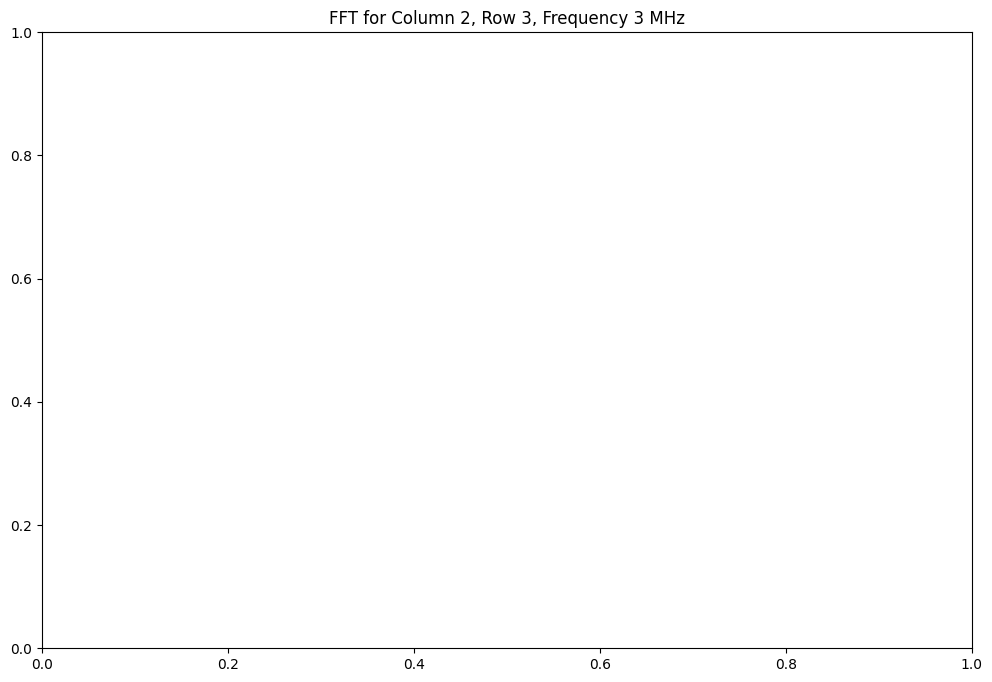

In [7]:
# plot the fft for all 4 MHz frequencies

thickness = [3.08, 6.87]

label_dict = {
    "Skull Position 1": "3.08 mm",
    "Skull Position 2": "6.87 mm",
    "Water": "No skull",
}

for _, position in positions.iterrows():
    col, row, freq = position["Column"], position["Row"], position["Frequency (MHz)"]

    # Check if the frequency is 4 MHz
    if freq == 3:
        plt.figure(figsize=(12, 8))
        plt.title(f"FFT for Column {col}, Row {row}, Frequency {freq} MHz")

        # load the data for each skull position
        for skull_position in label_dict.keys():
            row_data = metadata[
                (metadata["Column"] == col)
                & (metadata["Row"] == row)
                & (metadata["Position"] == skull_position)
                & (metadata["Frequency (MHz)"] == freq)
            ]

            if not row_data.empty:
                file_num = row_data["SDS Sample #"].values[0]
                if pd.notna(file_num) and is_integer(file_num):
                    filename = f"data/SDS{int(file_num):05d}.dat"
                    try:
                        df = pd.read_csv(filename, delimiter=",", header=None)
                        d = df.to_numpy()
                        t = d[:-1, 0]
                        v = d[:-1, 2]

                        tmin = 1e-5
                        freq_Hz = freq * 1e6

                        # pulse width is 1000 half-cycles
                        ncycles = 500
                        pulse_width_s = ncycles / freq_Hz
                        cutoff_freq = 2 / pulse_width_s

                        # restrict to pulse width data
                        t_mask = t <= tmin + pulse_width_s
                        t = t[t_mask]
                        v = v[t_mask]

                        # Apply Hann window
                        window = np.hanning(len(v))
                        v_windowed = v * window

                        # Compute FFT
                        fs = 1 / (t[1] - t[0])  # Sampling frequency
                        n = len(v_windowed)
                        fft_v = np.fft.fft(v_windowed)
                        freqs = np.fft.fftfreq(n, 1 / fs)

                        # Plot magnitude spectrum in log scale
                        plt.semilogy(
                            freqs[: n // 2] / 1e6,
                            np.abs(fft_v[: n // 2]),
                            label=label_dict[skull_position],
                            alpha=0.7,
                        )

                    except Exception as e:
                        print(f"Error processing file {filename}: {str(e)}")

        plt.xlabel("Frequency (MHz)")
        plt.ylabel("Magnitude (log scale)")
        plt.legend()
        plt.grid(True)
        plt.xlim(0.5, 10)  # Set x-axis limits from 0.5 to 10 MHz
        plt.show()